# Imports and set up

In [171]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

In [99]:
FILE = "../data/weekly_customer_complaints.csv"

In [100]:
complain_df = pd.read_csv(FILE, parse_dates=["week"], index_col=["week"])
complain_df = complain_df.asfreq("W-Mon")

# EDA

In [101]:
complain_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Freq: W-MON
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


In [102]:
complain_df["complaints"] = complain_df["complaints"].str.replace(",", "").astype(int)
complain_df["discount_rate"] = complain_df["discount_rate"].str.replace("%", "").astype(float)

In [103]:
complain_df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750,37.26,1,0,0
2018-01-08,1701,35.38,0,0,0
2018-01-15,1711,36.22,1,0,0
2018-01-22,1443,38.33,1,0,0
2018-01-29,1397,36.34,0,0,0


In [104]:
complain_df.describe()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
count,261.000000,261.000000,261.000000,261.000000,261.000000
mean,2684.191571,30.236207,0.226054,0.118774,0.026820
std,1084.000267,6.204702,0.419078,0.324144,0.161867
min,1077.000000,19.600000,0.000000,0.000000,0.000000
25%,1719.000000,25.180000,0.000000,0.000000,0.000000
50%,2570.000000,29.140000,0.000000,0.000000,0.000000
75%,3405.000000,35.220000,0.000000,0.000000,0.000000
max,7931.000000,59.200000,1.000000,1.000000,1.000000


In [105]:
complain_df.isna().sum()

complaints                 0
discount_rate              0
small_commercial_event     0
medium_commercial_event    0
big_commercial_event       0
dtype: int64

In [106]:
px.line(complain_df[["complaints", "discount_rate"]])

In [107]:
complain_df.loc[complain_df["complaints"].idxmax()]

complaints                 7931.00
discount_rate                37.59
small_commercial_event        0.00
medium_commercial_event       0.00
big_commercial_event          0.00
Name: 2022-11-21 00:00:00, dtype: float64

In [108]:
complain_df.loc[complain_df["discount_rate"].idxmax()]

complaints                 6738.0
discount_rate                59.2
small_commercial_event        0.0
medium_commercial_event       0.0
big_commercial_event          0.0
Name: 2020-11-23 00:00:00, dtype: float64

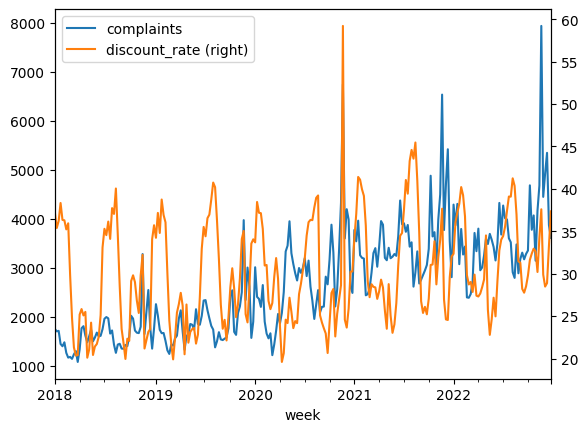

In [109]:
ax = complain_df["complaints"].plot(legend=True)
ax = complain_df["discount_rate"].plot(secondary_y=True, legend=True)
plt.show()

In [110]:
year_complain = complain_df.resample("YE").agg(["mean", "sum"])
year_complain[["complaints", "discount_rate"]]

complaints         discount_rate         
                   mean     sum          mean      sum
week                                                  
2018-12-31  1624.849057   86117     28.463396  1508.56
2019-12-31  1890.769231   98320     29.253654  1521.19
2020-12-31  2751.653846  143086     29.289808  1523.07
2021-12-31  3506.153846  182320     32.057692  1667.00
2022-12-31  3667.903846  190731     32.150577  1671.83

In [111]:
px.scatter(complain_df, "complaints", "discount_rate")

In [112]:
complain_df[["complaints", "discount_rate"]].corr()

,complaints,discount_rate
complaints,1.000000,0.280484
discount_rate,0.280484,1.000000


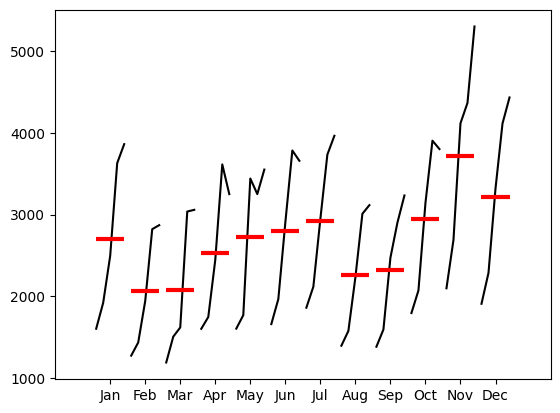

In [113]:
month_plot(complain_df["complaints"].resample("ME").mean())
plt.show()

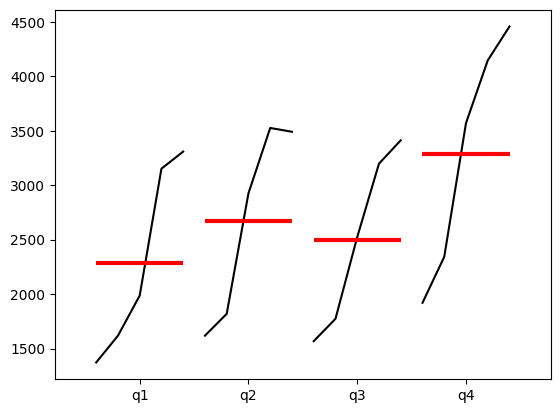

In [114]:
quarter_plot(complain_df["complaints"].resample("QE").mean())
plt.show()

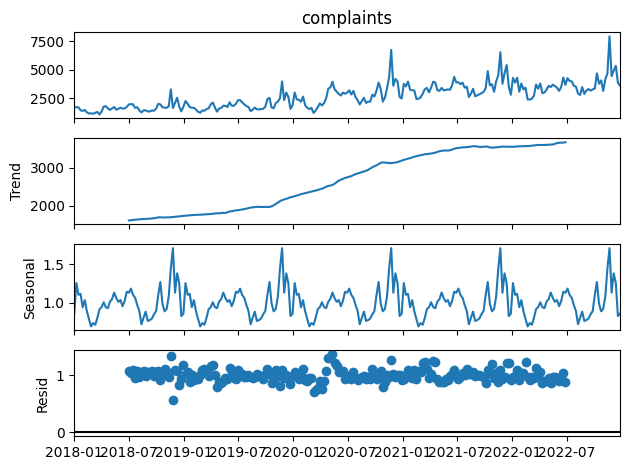

In [115]:
decomposition = seasonal_decompose(complain_df["complaints"], model="multiplicative", period=52)

fig = decomposition.plot()

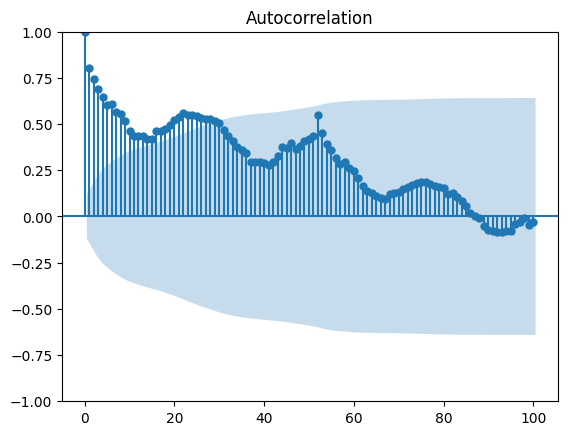

In [116]:
plot_acf(complain_df["complaints"], lags = 100)
plt.show()

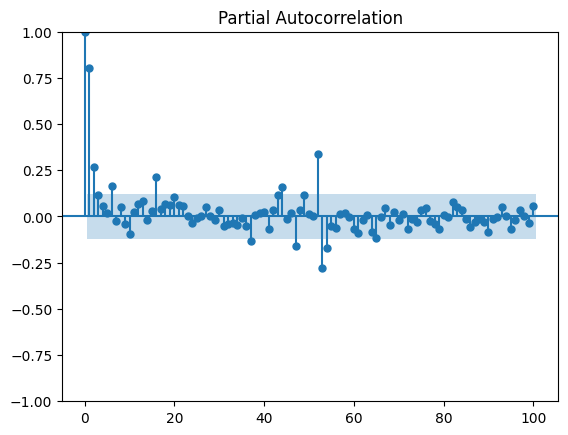

In [117]:
plot_pacf(complain_df["complaints"], lags = 100)
plt.show()

## Training & Testing

In [118]:
# Training and testing split
periods = 13
train, test = complain_df.iloc[:-periods, 0], complain_df.iloc[-periods:, 0]
train, test

(week
 2018-01-01    1750
 2018-01-08    1701
 2018-01-15    1711
 2018-01-22    1443
 2018-01-29    1397
               ... 
 2022-08-29    2885
 2022-09-05    3177
 2022-09-12    3306
 2022-09-19    3170
 2022-09-26    3279
 Freq: W-MON, Name: complaints, Length: 248, dtype: int64,
 week
 2022-10-03    3350
 2022-10-10    4679
 2022-10-17    3773
 2022-10-24    4065
 2022-10-31    3142
 2022-11-07    4164
 2022-11-14    4677
 2022-11-21    7931
 2022-11-28    4444
 2022-12-05    4920
 2022-12-12    5342
 2022-12-19    3868
 2022-12-26    3607
 Freq: W-MON, Name: complaints, dtype: int64)

## Simple Exponential Smoothing

In [119]:
model_simple = SimpleExpSmoothing(train).fit()
pred_simple = model_simple.forecast(len(test))

### Double Exponential Smoothing

In [124]:
model_double = ExponentialSmoothing(train, trend = "add").fit()
pred_double = model_double.forecast(len(test))

### Triple Exponential Smoothing

In [137]:
model_triple = ExponentialSmoothing(train, trend = "add", seasonal = "mul", seasonal_periods=52).fit()
pred_triple = model_triple.forecast(len(test))

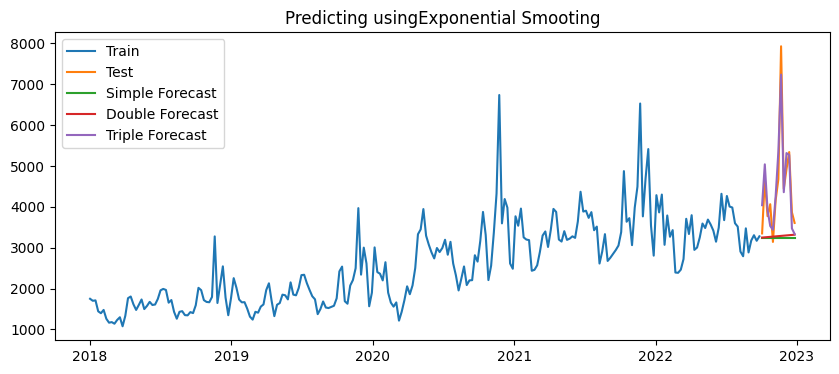

In [136]:
plt.figure(figsize=(10,4))
plt.plot(train, label = "Train")
plt.plot(test, label = "Test")
plt.plot(pred_simple, label = "Simple Forecast")
plt.plot(pred_double, label = "Double Forecast")
plt.plot(pred_triple, label = "Triple Forecast")
plt.title("Predicting usingExponential Smooting")
plt.legend()
plt.show()

In [139]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train, mode="lines", name="Train"))
fig.add_trace(go.Scatter(x=test.index, y=test, mode="lines", name="Test"))
fig.add_trace(go.Scatter(x=pred_simple.index, y=pred_simple, mode="lines", name="Simple Forecast"))
fig.add_trace(go.Scatter(x=pred_double.index, y=pred_double, mode="lines", name="Double Forecast"))
fig.add_trace(go.Scatter(x=pred_triple.index, y=pred_triple, mode="lines", name="Triple Forecast"))

fig.update_layout(
    title="Predicting using Exponential Smoothing",
    xaxis_title="Date",
    yaxis_title="Value",
    legend=dict(x=0, y=1, traceorder="normal"),
    width=1000, height=400
)

fig.show()


## Model Accuracy Test

In [160]:
mae = mean_absolute_error(test, pred_triple)
rsme = root_mean_squared_error(test, pred_triple)
mape = mean_absolute_percentage_error(test, pred_triple)

print(f" The MAE is {mae:.2f}")
print(f" The RSME is {rsme:,.2f}")
print(f" The MAPE is {mape * 100:,.2f}%")

 The MAE is 363.69
 The RSME is 425.49
 The MAPE is 8.44%


## Predict the Future

In [168]:
model = ExponentialSmoothing(complain_df["complaints"], trend= "add", seasonal="mul", seasonal_periods=52).fit()

In [170]:
pred = model.forecast(13)
pred

2023-01-02    4965.818193
2023-01-09    4478.067957
2023-01-16    4699.491737
2023-01-23    3814.093640
2023-01-30    4241.996332
2023-02-06    3726.266997
2023-02-13    3385.513023
2023-02-20    2879.444519
2023-02-27    2978.566977
2023-03-06    3044.187203
2023-03-13    3430.469182
2023-03-20    3923.798678
2023-03-27    3794.535229
Freq: W-MON, dtype: float64

In [190]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=complain_df.index, y=complain_df["complaints"], mode="lines", name="Actual"))
fig.add_trace(go.Scatter(x=pred.index, y=pred, mode="lines", name="Forecast"))

fig.update_layout(
    title="Predicting using Exponential Smoothing",
    xaxis_title="Date",
    yaxis_title="Value",
    legend=dict(x=0, y=1, traceorder="normal"),
    width=1000, height=400,
)

monthly_ticks = complain_df.resample("MS").mean().index  # month starts in your data

fig.update_xaxes(
    tickmode="linear",
    dtick="M1",            # one tick per month
    tickformat="%b %Y",    # e.g., Jan 2019
    tick0="2018-01-01"     # optional: align to month starts (pick your first month)
)


fig.show()
